# Importing Necessary Libraries

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MaxAbsScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Data & Pre-Processing 

In [62]:
# Load the data
df = pd.read_csv('./vgsales.csv')
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [63]:
# Get some information about dataset
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


,count,mean,std,min,25%,50%,75%,max
Rank,16598.0,8300.605254,4791.853933,1.00,4151.25,8300.50,12449.75,16600.00
Year,16327.0,2006.406443,5.828981,1980.00,2003.00,2007.00,2010.00,2020.00
NA_Sales,16598.0,0.264667,0.816683,0.00,0.00,0.08,0.24,41.49
EU_Sales,16598.0,0.146652,0.505351,0.00,0.00,0.02,0.11,29.02
JP_Sales,16598.0,0.077782,0.309291,0.00,0.00,0.00,0.04,10.22
Other_Sales,16598.0,0.048063,0.188588,0.00,0.00,0.01,0.04,10.57
Global_Sales,16598.0,0.537441,1.555028,0.01,0.06,0.17,0.47,82.74


In [64]:
df.isnull().sum()

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

In [65]:
# Handle missing values
df.dropna(inplace=True)

In [66]:
# Feature engineering: convert categorical data
categorical_features = ['Platform', 'Genre']
one_hot = OneHotEncoder(handle_unknown='ignore')
transformer = ColumnTransformer([("one_hot", one_hot, categorical_features)], remainder="passthrough")

# Prepare features and labels
X = df.drop(['Rank', 'Name', 'Global_Sales', 'Publisher', 'Year'], axis=1)
y = df['Global_Sales']

# Data normalization
scaler = MaxAbsScaler()

# Develop the models

In [67]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [68]:
# Create a modeling pipeline
linear_pipe = Pipeline([
    ('transformer', transformer),
    ('scaler', scaler),
    ('model', LinearRegression())
])

random_forest_pipe = Pipeline([
    ('transformer', transformer),
    ('scaler', scaler),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [69]:
# Fit models
linear_pipe.fit(X_train, y_train)
random_forest_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Platform', 'Genre'])])),
                ('scaler', MaxAbsScaler()),
                ('model', RandomForestRegressor(random_state=42))])

In [70]:
# Evaluate models
linear_predictions = linear_pipe.predict(X_test)
forest_predictions = random_forest_pipe.predict(X_test)

print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, linear_predictions)))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, forest_predictions)))
print("Linear Regression R^2:", r2_score(y_test, linear_predictions))
print("Random Forest R^2:", r2_score(y_test, forest_predictions))

Linear Regression RMSE: 0.005314912205317581
Random Forest RMSE: 0.7851768822635815
Linear Regression R^2: 0.9999922055729307
Random Forest R^2: 0.8298911077635349


In [71]:
# Create a KFold object to define the splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Adjust the cross-validation to use the pipeline
cv_scores_linear = cross_val_score(linear_pipe, X, y, cv=kf, scoring='neg_mean_squared_error')
cv_scores_forest = cross_val_score(random_forest_pipe, X, y, cv=kf, scoring='neg_mean_squared_error')

print("Linear Regression CV RMSE:", np.sqrt(-np.mean(cv_scores_linear)))
print("Random Forest CV RMSE:", np.sqrt(-np.mean(cv_scores_forest)))

Linear Regression CV RMSE: 0.005225279741387912
Random Forest CV RMSE: 0.4450442640034359


In [72]:
# Feature Importance from Random Forest
feature_importances = random_forest_pipe.named_steps['model'].feature_importances_
features = random_forest_pipe.named_steps['transformer'].transformers_[0][1].get_feature_names_out().tolist() + ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
feature_imp_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values('Importance', ascending=False)

# Visualization

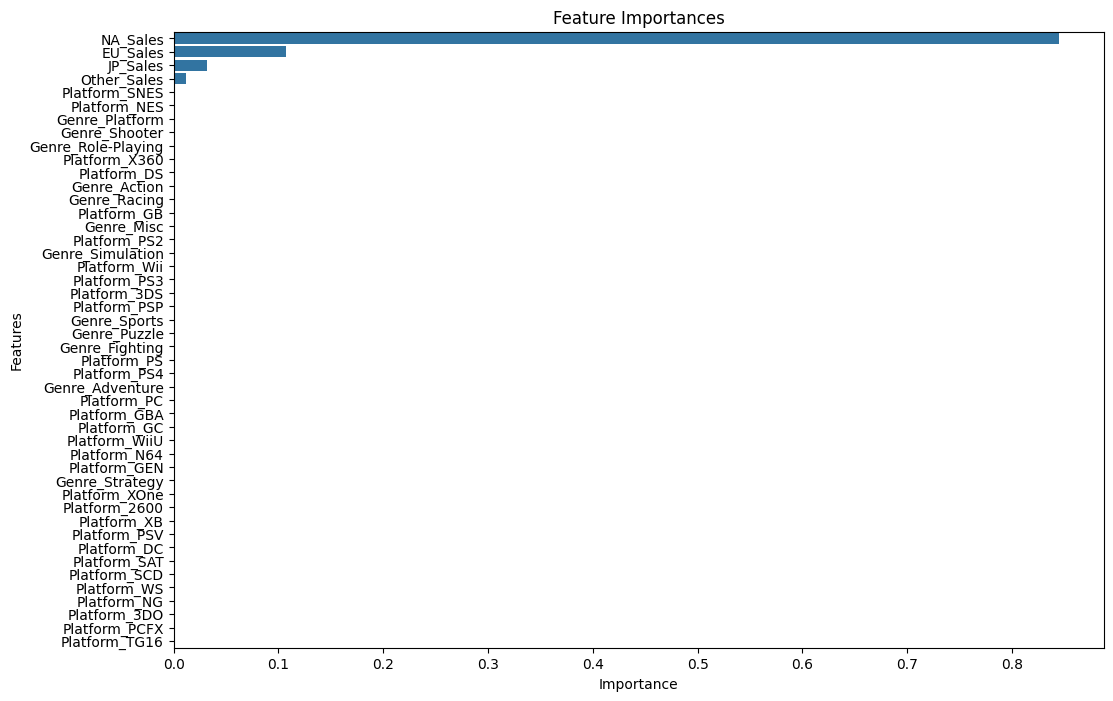

In [73]:
# Graph for feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_imp_df, x='Importance', y='Feature')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

C:\Users\nisha\AppData\Local\Temp\ipykernel_23316\1705886092.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')


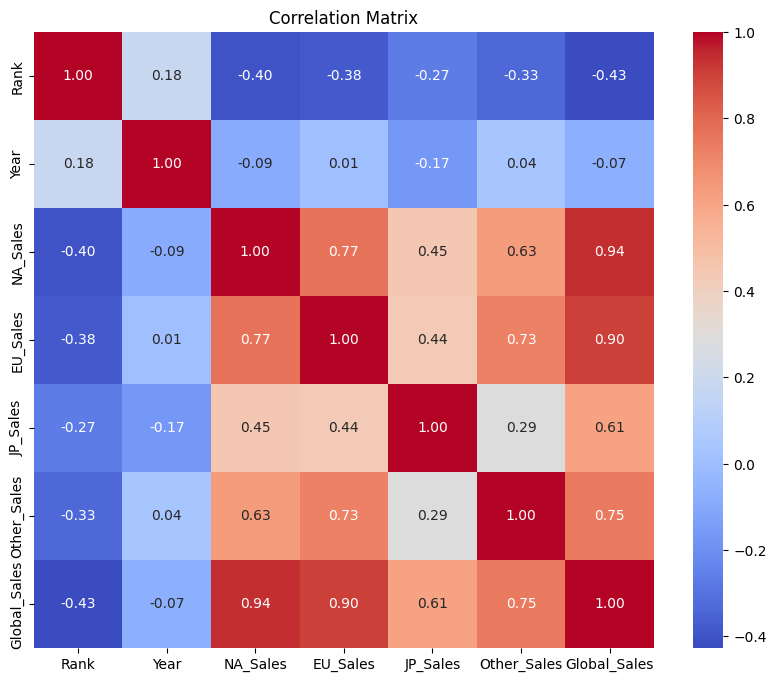

In [74]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

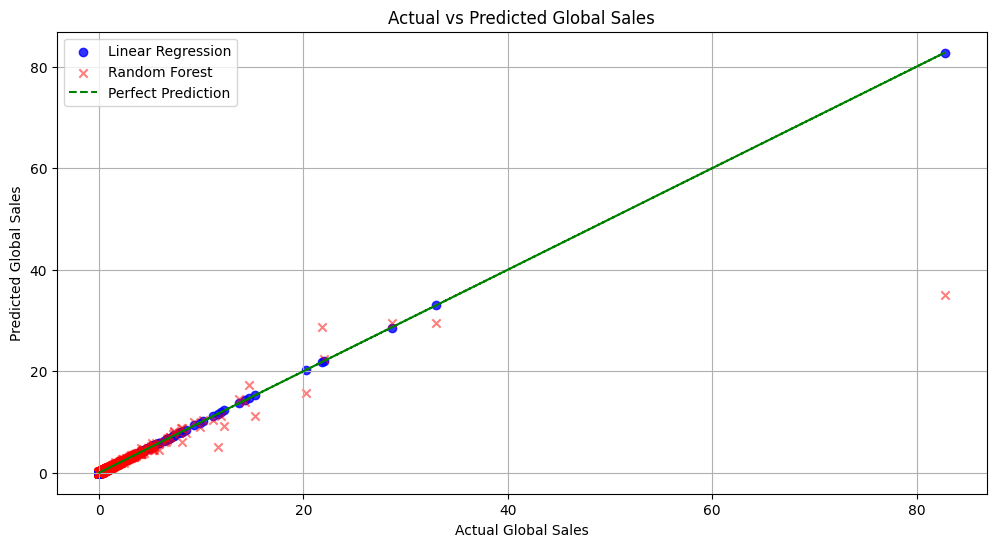

In [54]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, linear_predictions, alpha=0.8, label='Linear Regression', color='blue', marker='o')
plt.scatter(y_test, forest_predictions, alpha=0.5, label='Random Forest', color='red', marker='x')
plt.plot(y_test, y_test, 'g--', label='Perfect Prediction')  
plt.xlabel('Actual Global Sales')
plt.ylabel('Predicted Global Sales')
plt.title('Actual vs Predicted Global Sales')
plt.legend()
plt.grid(True)
plt.show()

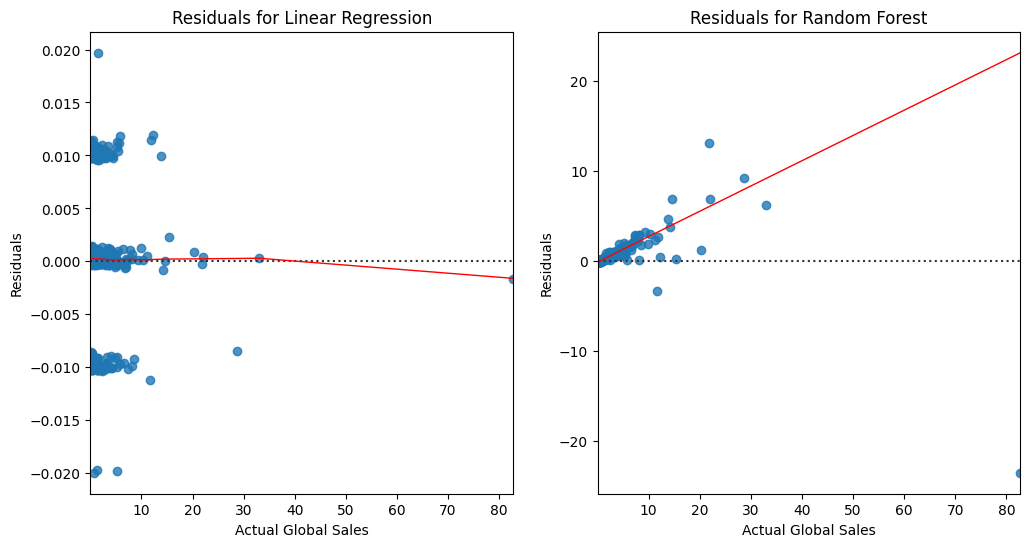

In [55]:
# Residual Plots for models
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.residplot(x=y_test, y=linear_predictions, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Residuals for Linear Regression')
plt.xlabel('Actual Global Sales')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
sns.residplot(x=y_test, y=forest_predictions, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Residuals for Random Forest')
plt.xlabel('Actual Global Sales')
plt.ylabel('Residuals')
plt.show()